In [122]:
import pandas as pd
df = pd.read_csv("海康威视2010-05-05.csv")
# print(df)df.dropna(inplace=True)
pre_days = 10

In [123]:
def Stock_Price_LSTM_Data_precesing(df,mem_his_days,pro_days):
    df=df.set_index(['date'])
    df=df.dropna() # 注意删除空值
    df=df.drop('code',axis=1)
    df['label']=df['close'].shift(-pre_days)

    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    sca_X = scaler.fit_transform(df.iloc[:,:-1])
#     print(sca_X)

    # 使用队列
    from collections import deque
    deq = deque(maxlen=mem_his_days)

    X = []
    for i in sca_X:
        deq.append(list(i))
        if len(deq)==mem_his_days:
            X.append(list(deq))

    X_lately = X[-pre_days:]
    # 特征向量空间
    X = X[:-pre_days]
#     print(len(X))
#     print(X[0])
#     print(len(X_lately))

    y=df['label'].values[mem_his_days-1:-pre_days]
#     print(len(y))
#     print(y)
    import numpy as np
    X = np.array(X)
    y = np.array(y)
#     print(X.shape)
#     print(y.shape)
    return df,X,y,X_lately

In [124]:
# df,X,y,X_lately = Stock_Price_LSTM_Data_precesing(df,5,10)
# print(df.index)
# print(X[0])
# print(y)
# print(len(X_lately))

In [125]:
# mem_days=[5,10,15]
# lstm_layers=[1,2,3]
# dense_layers = [1,2,3]
# units = [8,16,32]# 神经元
mem_days=[10]
lstm_layers=[2]
dense_layers = [3]
units = [8]# 神经元
# 模型优化 自动训练寻找最优模型
from tensorflow.keras.callbacks import ModelCheckpoint
for the_mem_days in mem_days:
    for the_lstm_layers in lstm_layers:
        for the_dense_layers in dense_layers:
            for the_units in units:
                filepath = './best_models/{val_mape:.2f}_{epoch:02d}_'+f'men_{the_mem_days}_lstm_{the_lstm_layers}_dense_{the_dense_layers}_unit_{the_units}'
                checkpoint = ModelCheckpoint(
                    filepath=filepath,
                    save_weights_only=False,
                    monitor='val_mape', # 这里使用平均误差率  val_accuracy（准确率）（主要用于分类）
                    mode='min',# 平均误差率越小越好
                    save_best_only=True)
                
                df,X,y,X_lately = Stock_Price_LSTM_Data_precesing(df,the_mem_days,pre_days)
                from sklearn.model_selection import train_test_split
                X_train,X_test,y_train,y_test = train_test_split(X,y,shuffle=False,test_size=0.1)
                
                 # 构建神经网络
                import tensorflow as tf
                from tensorflow.keras.models import Sequential
                # 三层：lstm，Dense，删除部分神经元
                from tensorflow.keras.layers import LSTM,Dense,Dropout
                model = Sequential()
                # 激活函数relu，循环神经网络要求第一个return
                model.add(LSTM(the_units,input_shape=X.shape[1:],activation='relu',return_sequences=True))
                # 防止过拟合，删除0.1%的神经元
                model.add(Dropout(0,1))

                for i in range(the_lstm_layers):
                    # 此处input_shape由上一层决定
                    model.add(LSTM(the_units,activation='relu',return_sequences=True))
                    model.add(Dropout(0,1))
                    
                model.add(LSTM(the_units,activation='relu'))
                model.add(Dropout(0,1))
                # 构建全连接层
                for i in range(the_dense_layers):
                    model.add(Dense(the_units,activation='relu'))
                    model.add(Dropout(0,1))
                # 输出层，只输出一个值
                model.add(Dense(1))
                # 编译
                model.compile(optimizer='adam',# 优化器
                             loss='mse',# 损失函数（此处要求回归）
                             metrics=['mape'])# 评价函数（此处要求回归）
                # 训练模型 训练数据集，32，50期训练，校验数据集
                model.fit(X_train,y_train,batch_size=32,epochs=50,validation_data=(X_test,y_test),callbacks=[checkpoint])     

Epoch 1/50
83/84 [============================>.] - ETA: 0s - loss: 439.3389 - mape: 75714.4062

INFO:tensorflow:Assets written to: ./best_models\32.08_01_men_10_lstm_2_dense_3_unit_8\assets


INFO:tensorflow:Assets written to: ./best_models\32.08_01_men_10_lstm_2_dense_3_unit_8\assets


84/84 [==============================] - 20s 170ms/step - loss: 435.6216 - mape: 74953.1406 - val_loss: 249.3977 - val_mape: 32.0771
Epoch 2/50
81/84 [===========================>..] - ETA: 0s - loss: 29.8467 - mape: 2708413.7500

INFO:tensorflow:Assets written to: ./best_models\7.54_02_men_10_lstm_2_dense_3_unit_8\assets


INFO:tensorflow:Assets written to: ./best_models\7.54_02_men_10_lstm_2_dense_3_unit_8\assets


84/84 [==============================] - 14s 164ms/step - loss: 29.2992 - mape: 2616557.5000 - val_loss: 12.8443 - val_mape: 7.5412
Epoch 3/50
84/84 [==============================] - ETA: 0s - loss: 9.8079 - mape: 764962.6875

INFO:tensorflow:Assets written to: ./best_models\6.65_03_men_10_lstm_2_dense_3_unit_8\assets


INFO:tensorflow:Assets written to: ./best_models\6.65_03_men_10_lstm_2_dense_3_unit_8\assets


84/84 [==============================] - 14s 166ms/step - loss: 9.8079 - mape: 764962.6875 - val_loss: 9.8895 - val_mape: 6.6527
Epoch 4/50
84/84 [==============================] - 1s 16ms/step - loss: 7.9877 - mape: 521853.5625 - val_loss: 12.9982 - val_mape: 7.5069
Epoch 5/50
84/84 [==============================] - 1s 16ms/step - loss: 7.2815 - mape: 395550.8750 - val_loss: 14.5016 - val_mape: 8.1855
Epoch 6/50
84/84 [==============================] - 1s 16ms/step - loss: 6.4330 - mape: 324844.0312 - val_loss: 32.0543 - val_mape: 12.2285
Epoch 7/50
84/84 [==============================] - ETA: 0s - loss: 6.3921 - mape: 403097.8438

INFO:tensorflow:Assets written to: ./best_models\6.53_07_men_10_lstm_2_dense_3_unit_8\assets


INFO:tensorflow:Assets written to: ./best_models\6.53_07_men_10_lstm_2_dense_3_unit_8\assets


84/84 [==============================] - 14s 163ms/step - loss: 6.3921 - mape: 403097.8438 - val_loss: 10.0169 - val_mape: 6.5281
Epoch 8/50
84/84 [==============================] - 1s 16ms/step - loss: 6.4256 - mape: 330940.8438 - val_loss: 15.1633 - val_mape: 8.1302
Epoch 9/50
84/84 [==============================] - 2s 18ms/step - loss: 5.4998 - mape: 246874.0312 - val_loss: 13.3466 - val_mape: 7.5372
Epoch 10/50
84/84 [==============================] - 1s 16ms/step - loss: 5.4223 - mape: 333943.0938 - val_loss: 26.8624 - val_mape: 10.1835
Epoch 11/50
84/84 [==============================] - 1s 16ms/step - loss: 5.0816 - mape: 218622.5000 - val_loss: 19.6057 - val_mape: 9.0032
Epoch 12/50
84/84 [==============================] - 1s 17ms/step - loss: 5.1462 - mape: 257447.6406 - val_loss: 25.6038 - val_mape: 10.0041
Epoch 13/50
84/84 [==============================] - 2s 19ms/step - loss: 6.0535 - mape: 167482.9688 - val_loss: 10.7295 - val_mape: 6.6210
Epoch 14/50
84/84 [===========

In [126]:
from tensorflow.keras.models import load_model
best_model = load_model('./best_models/5.78_03_men_10_lstm_2_dense_3_units_8')

In [127]:
best_model.summary()

Model: "sequential_93"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_364 (LSTM)             (None, 10, 8)             448       
                                                                 
 dropout_545 (Dropout)       (None, 10, 8)             0         
                                                                 
 lstm_365 (LSTM)             (None, 10, 8)             544       
                                                                 
 dropout_546 (Dropout)       (None, 10, 8)             0         
                                                                 
 lstm_366 (LSTM)             (None, 10, 8)             544       
                                                                 
 dropout_547 (Dropout)       (None, 10, 8)             0         
                                                                 
 lstm_367 (LSTM)             (None, 8)               

In [128]:
best_model.evaluate(X_test,y_test)
pre = best_model.predict(X_test)
print(pre)

10/10 [==============================] - 1s 5ms/step
[[50.79973 ]
 [50.09104 ]
 [50.633278]
 [50.870888]
 [50.47028 ]
 [50.641926]
 [50.309345]
 [50.05232 ]
 [50.282654]
 [50.961594]
 [50.975777]
 [50.571884]
 [50.200943]
 [49.936882]
 [50.05077 ]
 [50.426353]
 [50.611237]
 [50.740364]
 [51.536957]
 [51.66652 ]
 [51.950493]
 [52.575375]
 [52.857468]
 [52.538624]
 [51.87896 ]
 [51.555107]
 [51.570984]
 [51.238228]
 [50.99243 ]
 [50.441803]
 [50.392017]
 [50.18395 ]
 [50.44133 ]
 [50.28569 ]
 [48.962864]
 [48.303017]
 [48.168297]
 [48.088497]
 [48.007523]
 [47.84444 ]
 [47.034   ]
 [47.00331 ]
 [47.357403]
 [47.63748 ]
 [47.877106]
 [47.8242  ]
 [48.03687 ]
 [48.4088  ]
 [48.421944]
 [48.46606 ]
 [48.29093 ]
 [48.116703]
 [47.78351 ]
 [47.663834]
 [47.266796]
 [46.232956]
 [45.803482]
 [45.823196]
 [46.59334 ]
 [47.22398 ]
 [47.465008]
 [47.930363]
 [48.65017 ]
 [49.956135]
 [50.335007]
 [50.66964 ]
 [50.696323]
 [50.131355]
 [49.506172]
 [48.73738 ]
 [48.22314 ]
 [47.349094]
 [47.252876

In [129]:
model.evaluate(X_test,y_test)

10/10 [==============================] - 0s 5ms/step - loss: 18.7436 - mape: 8.3771


[18.743589401245117, 8.377114295959473]

Index(['2021-09-28', '2021-09-29', '2021-09-30', '2021-10-08', '2021-10-11',
       '2021-10-12', '2021-10-13', '2021-10-14', '2021-10-15', '2021-10-18',
       ...
       '2022-12-08', '2022-12-09', '2022-12-12', '2022-12-13', '2022-12-14',
       '2022-12-15', '2022-12-16', '2022-12-19', '2022-12-20', '2022-12-21'],
      dtype='object', name='date', length=299)


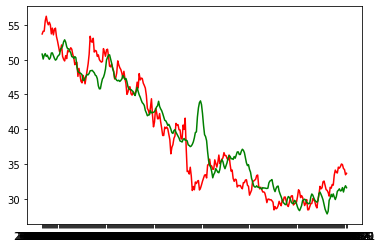

In [130]:
import matplotlib.pyplot as plt

df_time = df.index[-len(y_test):]
print(df_time)
plt.plot(df_time,y_test,color='red',label='price')
plt.plot(df_time,pre,color='green',label='price')
plt.show()